# Metadata

**Author**: Ejay Aguirre

**Last Updated**: 07-30-2025

**Links**: https://data.oceannetworks.ca/DataSearch?treeType=27&locationCode=NCBC&property=seawatertemperature

# Introduction

The dataset is from Barkley Canyon Upper Slope for water temperature. 
It demonstrates an alternative approach to accessing ONC data via the ERDDAP API.

This notebook documents an alternative approach to accessing ONC data via the ERDDAP API. 
However, this method was ultimately not used for the final analysis due to missing data from certain years.
The following problems are just as listed:
1. 1-Year time series limited to having to merge datasets together.
2. ReadTimeouts due to large files being requested multiple times.
3. Time frames are required and since there were limits to the datasets json data was required. 
4. Takes up a lot of memory around 13 GBs

This notebook is preserved as a record of the research process and the exploration of different data sources.

### Required Libraries

This notebook requires the following Python Libraries:
* `matplotlib`
* `xarray`
* `erddapy`

You can install them using the following command:
```bash
!pip install matplotlib xarray erddapy

In [2]:
!pip install matplotlib xarray erddapy -q

In [1]:
from erddapy import ERDDAP
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import xarray as xr

In [2]:
import requests
'''
A function that accesses the datasetID's index json to capture its time range.
It is needed as a constraint in requesting it's data.

Parameters:
- Dataset_id (str): the datasets id found from ONC's ERDDAP page.

Returns:
The start time and end time for the dataset id.
'''
def get_time_range(dataset_id):
    url = f"https://dap.oceannetworks.ca/erddap/info/{dataset_id}/index.json"
    try:
        r = requests.get(url, timeout = 30)
        r.raise_for_status()
        metadata = r.json()
        rows = metadata["table"]["rows"]
        
        start_time, end_time = None, None
        for row in rows:
            if row[:3] == ["attribute", "NC_GLOBAL", "time_coverage_start"]:
                start_time = row[4]
            elif row[:3] == ["attribute", "NC_GLOBAL", "time_coverage_end"]:
                end_time = row[4]

        return start_time, end_time
    except Exception:
        print(f"Error fetching time range for {dataset_id}")
        return None, None

In [3]:
import xarray as xr

"""
A function that query the ERDDAP server for the desired dataset.
It builds a query URL to search the ONC ERDDAP catalog.

Parameters:
- dataset_id (str): dataset id from ONC's catalog
- start (str): the start time constriant
- end (str): the end time constriant

Return:
A dataset fetched from the generated url.
"""
def load_dataset(dataset_id, start, end):
    """Load dataset from ONC ERDDAP as xarray.Dataset with time constraints."""
    e = ERDDAP(
        server = "https://dap.oceannetworks.ca/erddap",
        protocol = "tabledap",
    )
    e.dataset_id = dataset_id
    e.constraints = {
        "time>=": start,
        "time<=": end
    }
    
    e.variables = [
        "Temperature",  # Case-sensitive, match ERDDAP
    ]
    try:
        ds = e.to_xarray()
        print(f"Fetched {dataset_id}")
        return ds
    except Exception as e:
        print(f"Error loading {dataset_id}: {e}")
        return None

In [4]:
# Initalizes an empty list of datasets
# This is used to hold the many datasets queries due to the slicing from ONC's data catalog
datasets = []

In [5]:
import time

# List of dataset IDs to process
# Be sure to change the datasets ids to designated datasets
dataset_ids = [
    "scalar_117354",
    "scalar_117686", 
    "scalar_118809", 
    "scalar_1189201", # No Temperature
    "scalar_1190473", 
    "scalar_1192792", 
    "scalar_1194404", 
    "scalar_1200612", 
    "scalar_1202976", 
    "scalar_1205219", 
    "scalar_1209170", 
    "scalar_1214273", 
    "scalar_1217188",
]

for ds_id in dataset_ids:
    print(f"Processing dataset: {ds_id}")
    
    # Fetch start and end time
    start, end = get_time_range(ds_id)
    if not start or not end:
        print(f"Skipping {ds_id} due to missing time range.")
        continue

    print(f"Time range: {start} to {end}")

    # Load dataset using time range
    ds = load_dataset(ds_id, start, end)
    if ds is not None:
        datasets.append(ds)
        print(f"Appeneded Dataset: {ds_id}")
    else:
        print(f"Error Appending Dataset: {ds_id}")
    # Pause to be respectful of ERDDAP rate limits
    time.sleep(5)
print("Done")

Processing dataset: scalar_117354
Time range: 2009-07-26T14:38:41.000Z to 2010-05-17T03:37:14.000Z
Fetched scalar_117354
Appeneded Dataset: scalar_117354
Processing dataset: scalar_117686
Time range: 2010-05-18T03:16:59.000Z to 2011-07-17T00:54:37.000Z
Fetched scalar_117686
Appeneded Dataset: scalar_117686
Processing dataset: scalar_118809
Time range: 2012-05-29T10:12:41.000Z to 2013-05-10T15:20:32.000Z
Fetched scalar_118809
Appeneded Dataset: scalar_118809
Processing dataset: scalar_1189201
Time range: 2013-05-10T17:21:29.000Z to 2014-05-03T18:36:45.000Z
Error loading scalar_1189201: Error {
    code=400;
    message="Bad Request: Query error: Unrecognized variable=\"Temperature\".";
}

Error Appending Dataset: scalar_1189201
Processing dataset: scalar_1190473
Time range: 2014-05-03T18:59:31.000Z to 2015-09-17T00:31:58.000Z
Error loading scalar_1190473: The read operation timed out
Error Appending Dataset: scalar_1190473
Processing dataset: scalar_1192792
Time range: 2015-09-17T13:05:

In [11]:
'''
Fetch the datsets that were not appended, due to read operation time out.
Be sure to change some of the functions to fit best with the data.
'''

ds_id = "scalar_1214273"
temp_start, temp_end = get_time_range(ds_id)
temp_load = load_dataset(ds_id, temp_start, temp_end)
datasets.append(temp_load)

Fetched scalar_1214273


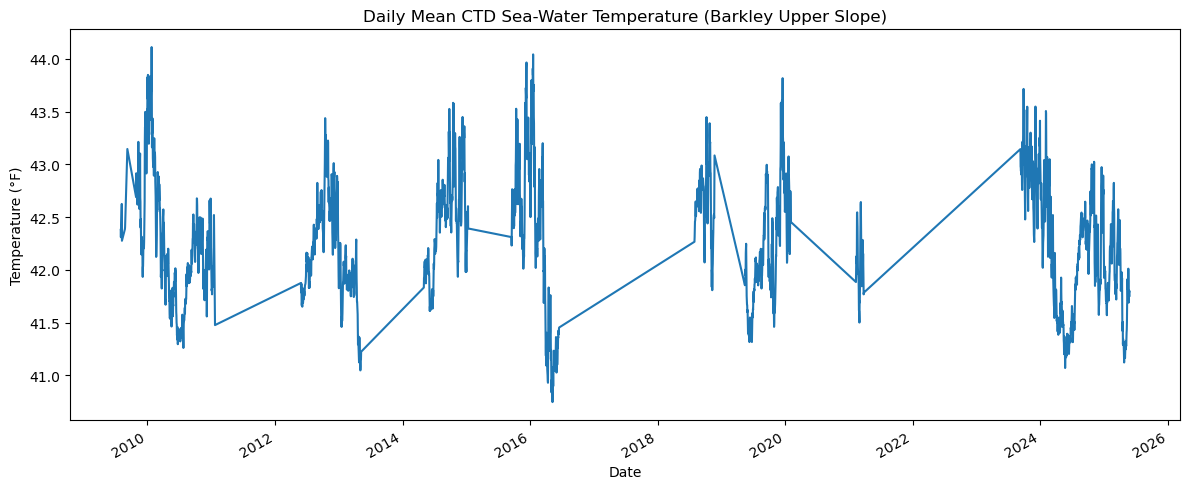

In [21]:
import pandas as pd

# Build one daily dataframe per dataset, then concat
df_list = []
for ds in datasets:
    if not isinstance(ds, xr.Dataset):
        continue
    if "Temperature" not in ds:
        continue

    # Convert to fahrenheit
    daF = (ds["Temperature"] - 273.15) * 9/5 + 32
    daF = daF.rename("temperature")

    # Ensure a time coordinate exists
    if "time" not in daF.coords and "time" in ds:
        daF = daF.assign_coords(time=ds["time"])
    if "time" not in daF.coords:
        raise ValueError("No 'time' coordinate found for one of the datasets.")

    # Resample in xarray first
    daily_da = daF.resample(time = "1D").mean(skipna=True)

    # Convert to pandas AFTER resampling
    daily_df = daily_da.to_dataframe().reset_index()

    # Drop non-time dims
    for col in ("timeseries", "obs"):
        if col in daily_df.columns:
            daily_df = daily_df.drop(columns=[col])

    # Tag cast id
    cast_id = ds["timeseries_id"].item() if "timeseries_id" in ds else "unknown"
    daily_df["cast_id"] = str(cast_id)

    df_list.append(daily_df)

# Concatenate all casts
df_all = pd.concat(df_list, ignore_index = True).dropna(subset = ["time", "temperature"])
df_all["time"] = pd.to_datetime(df_all["time"], utc = True)
df_all = df_all.sort_values("time")

# Average across casts
daily_mean = df_all.groupby("time")["temperature"].mean()

# Plot
plt.figure(figsize=(12,5))
daily_mean.plot()
plt.title("Daily Mean CTD Sea-Water Temperature (Barkley Upper Slope)")
plt.ylabel("Temperature (°F)")
plt.xlabel("Date")
plt.tight_layout()
plt.show()


### Conclusion

This notebook illustrates the process of exploring alternative data access methods in a scientific workflow. While the ERDDAP approach was not ultimately used, it provided valuable insights into the challenges and opportunities of different data sources, reinforcing the decision to pursue a direct API approach for the final analysis.